In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

# tensorflow imports
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Reshape, multiply
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day, create_submission, select_day_nums
from evaluation import Referee, RapidReferee, CrossValiDataGenerator
from agent import KDayMeanTimesWeeklyPattern, AggregateAgent
from train import BatchCreator, Logger, make_loss

In [3]:
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions/'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for MacOS TF bug

# General settings for figures
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 13})  # 12, 16
plt.rcParams["savefig.bbox"] = 'tight'

# Top Down for M5Forecast - Accuracy - Seasonality
This notebook investigates the Top Down approach for the M5Forecast - Accuracy challenge. Here, the aggregated sales of the stores are predicted directly by the model, instead of calculating the sales by aggregating product-level predictions.  

In [4]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# Set up generator
cv_generator = CrossValiDataGenerator(sales_train_validation)
sales_train, sales_true = cv_generator.get_train_val_split(fold=10, train_size=-1)

# create referee for fold 10
ref = Referee(sales_true, sales_train, sell_prices, calendar)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


## Seasonality - weekly pattern
Here the weekly pattern is substracted from the aggregated sales, then a simple 1D CNN is trained, after which the weekly pattern is restored. 

In [5]:
sales = sales_train.groupby(['store_id']).sum()
sales = sales.T

In [6]:
wday_cols = {}

for i in range(1, 1+7):
    # select days from a certain day of the week
    cols = list(calendar[calendar.wday == i].d.values)
    col_name = calendar[calendar.wday == i].weekday.values[0]
    # filter days to match training set
    cols = [d for d in cols if d in sales.index]
    wday_cols[col_name] = cols
    print("{} is day nr. {} of the week".format(col_name, i))

Saturday is day nr. 1 of the week
Sunday is day nr. 2 of the week
Monday is day nr. 3 of the week
Tuesday is day nr. 4 of the week
Wednesday is day nr. 5 of the week
Thursday is day nr. 6 of the week
Friday is day nr. 7 of the week


In [7]:
mean_sales = {name: sales.loc[cols].mean().mean() for (name, cols) in wday_cols.items()}

In [8]:
for wday, num in mean_sales.items():
    sales.loc[wday_cols[wday]] /= num

In [9]:
num_sales = [sales.loc[cols].sum().sum() for cols in wday_cols.values()]
num_sales

[2340.0000000000005,
 2329.999999999999,
 2330.0,
 2340.0000000000005,
 2330.0,
 2329.9999999999995,
 2330.0]

## Performance weekly pattern removed and restored

In [10]:
def preprocess_substract_weekly_pattern(sales, prices=None, calendar=None, norm=None):
    """Convert sales to a suitable format for the BatchCreator"""
    # prices and calendar inputs are for compatibility
    
    # Calculate aggregated sales
    df = sales.groupby(['store_id']).sum()
    
    # Transpose sales such that d_num_start, ... is the index
    df = df.T
    
    # Substract weekly pattern
    wday_cols = {}

    for i in range(1, 1+7):
        # select days from a certain day of the week
        cols = list(calendar[calendar.wday == i].d.values)
        col_name = calendar[calendar.wday == i].weekday.values[0]
        # filter days to match training set
        cols = [d for d in cols if d in df.index]
        wday_cols[col_name] = cols
    
    mean_sales = {name: df.loc[cols].mean().mean() for (name, cols) in wday_cols.items()}

    for wday, num in mean_sales.items():
        df.loc[wday_cols[wday]] /= num
    
    # Normalize
    if norm is None:
        norm = df.max().max()
    df /= norm
    
    return df, (norm, mean_sales)

In [11]:
# Get suitable train df
train_df, (train_norm, mean_sales) = preprocess_substract_weekly_pattern(sales_train, calendar=calendar)
features = train_df.columns

# Set up batch creator
window_in, window_out = 28, 28
batch_creator = BatchCreator(df=train_df, features=features, labels=features, 
                             window_in=window_in, window_out=window_out)

# Test if batch creator works
x, y = next(batch_creator.flow())
print("Input shape: {}, output shape: {}".format(x.shape, y.shape))
batch_creator.on_epoch_end()  # reset generator

Input shape: (32, 28, 10), output shape: (32, 28, 10)


In [12]:
def get_model(inp_shape, out_shape, loss='MSE'):
    # clear previous sessions
    K.clear_session()

    # add first layer with correct input size
    inp = Input(shape=inp_shape, name="input")
    x = Reshape((np.prod(inp_shape), 1))(inp)
    
    x = Conv1D( 8, kernel_size=3, padding="same", activation='relu')(x)
    x = Conv1D(16, kernel_size=3, padding="same", activation='relu')(x)
    x = Conv1D(32, kernel_size=3, padding="same", activation='relu')(x)

    out = Conv1D(1, kernel_size=1, activation='linear', name='output')(x)
    out = Reshape(out_shape)(out)
    
    model = Model(inputs=inp, outputs=out)

    model.compile(loss=loss, optimizer='adam', metrics=['MSE', loss])
    
    return model

model = get_model(inp_shape=(window_in, batch_creator.n_features), 
                  out_shape=(window_out, batch_creator.n_labels))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 10)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 280, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 16)           400       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 280, 32)           1568      
_________________________________________________________________
output (Conv1D)              (None, 280, 1)            33        
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 10)            0     

In [13]:
class AggregateAgentExplicitWeeklyPattern(AggregateAgent):
    """Agent to predict sales on aggregate level, with weekly pattern explicitly
    removed during training and restored to the predictions. """

    def __init__(self, weekly_pattern, calendar, model, train_norm, features, labels, window_in=28):
        super().__init__(model, train_norm, features, labels, window_in=window_in)
        self.weekly_pattern = weekly_pattern
        self.calendar = calendar

    def predict(self, train_df, val_day_nums):
        sales_pred = super().predict(train_df, val_day_nums)
        
        # restore weekly pattern
        for wday, norm_const in self.weekly_pattern.items():
            # select days
            cols = list(calendar[calendar.weekday == wday].d)
            # filter days to match predictions
            cols = [d for d in cols if d in sales_pred.index]
            sales_pred.loc[cols] *= norm_const
        
        return sales_pred

agent = AggregateAgentExplicitWeeklyPattern(weekly_pattern=mean_sales, calendar=calendar, model=model, 
                                            train_norm=train_norm, features=features, labels=features)

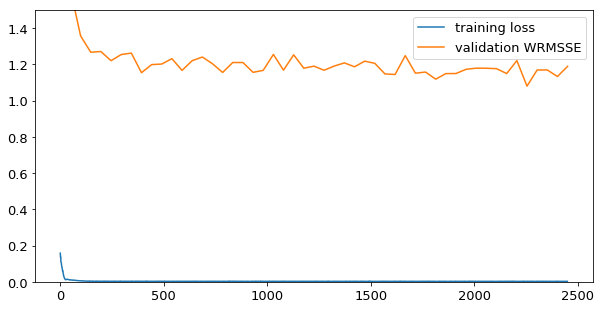

49/49 [==============================] - 8s 168ms/step - loss: 0.0025 - MSE: 0.0025


In [14]:
logger = Logger(ref=ref, cv_generator=cv_generator, calendar=calendar, train_norm=train_norm, 
                features=features, labels=features,
                agent=agent, preprocess_func=preprocess_substract_weekly_pattern, 
                folds = np.arange(1, 1+10), plot_loss_max=1.5)

history = model.fit(batch_creator.flow(), epochs=50,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

## Evaluation per fold

In [15]:
# evaluate model on final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

Mean WRMSSE level 3: 1.1889806449238847


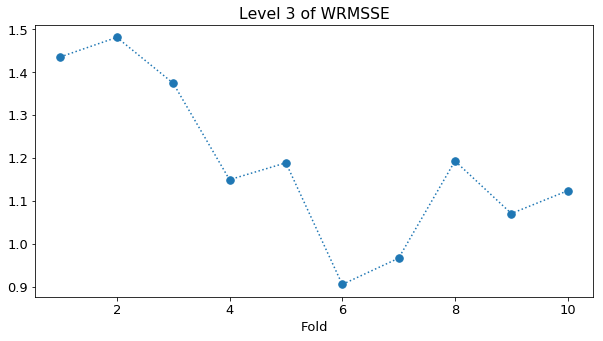

In [16]:
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()

**Result**: that's really just bad. 

## Seasonality - events

nan


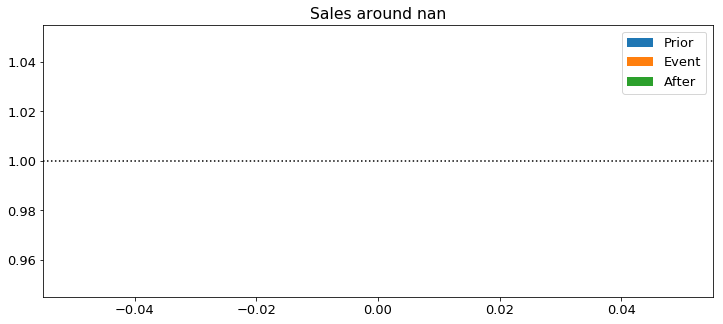

SuperBowl


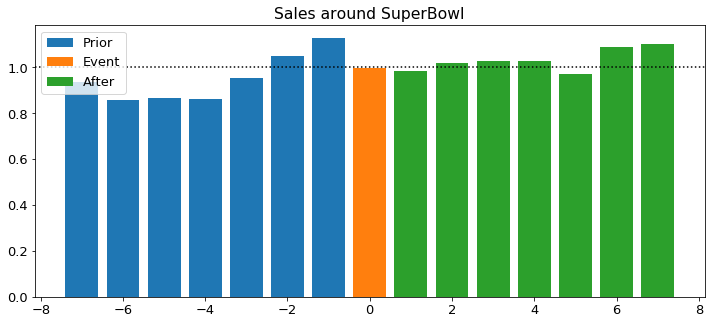

ValentinesDay


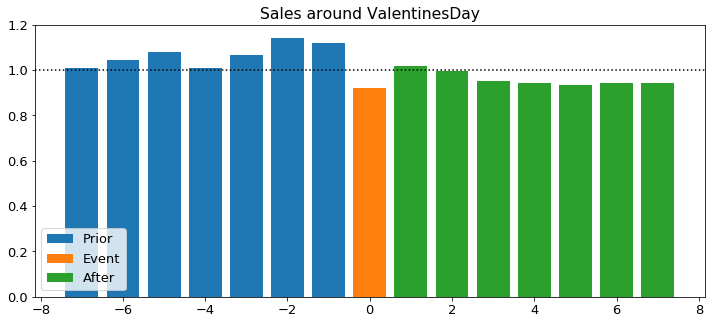

PresidentsDay


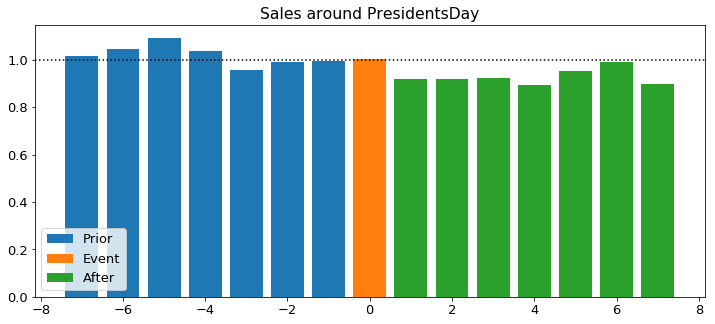

LentStart


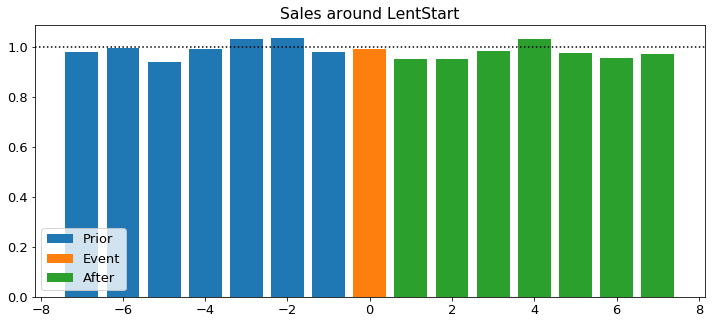

LentWeek2


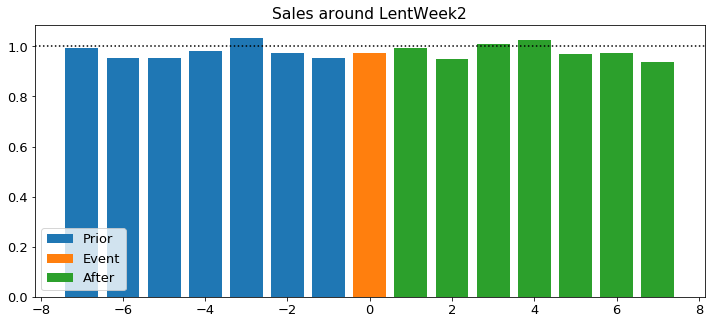

StPatricksDay


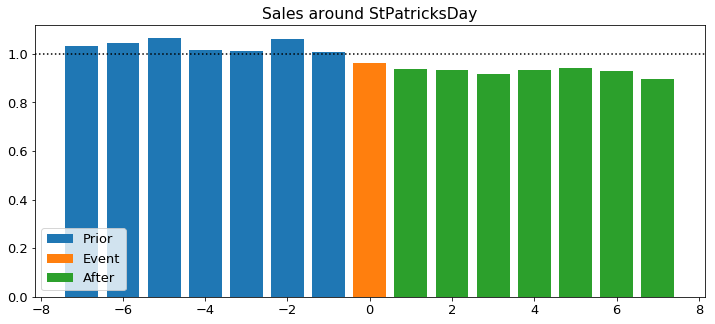

Purim End


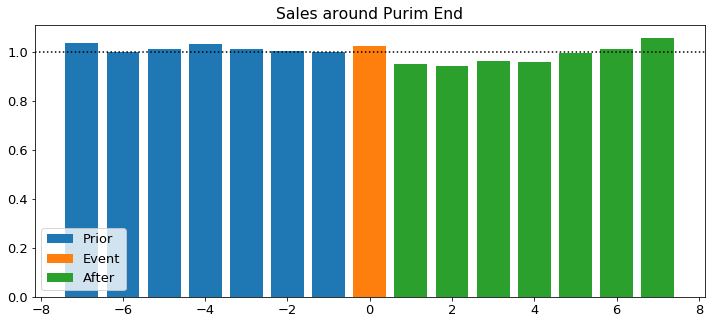

OrthodoxEaster


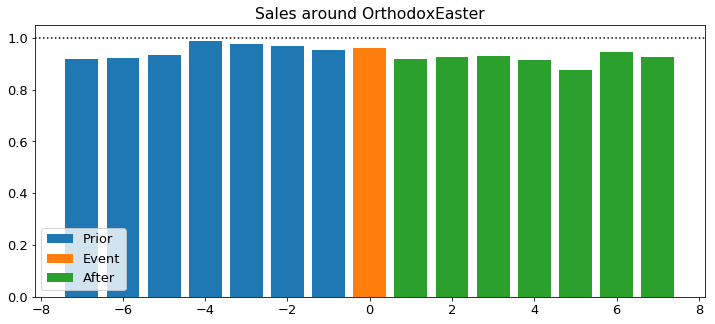

Pesach End


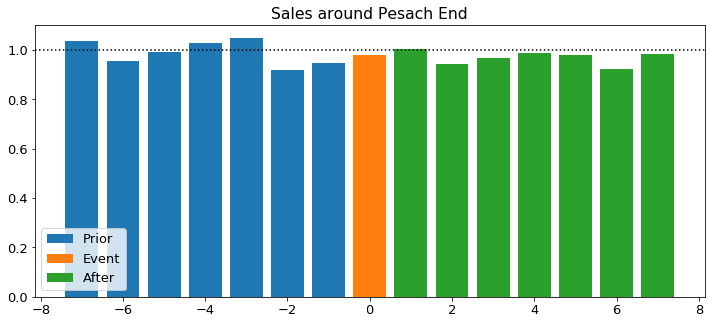

Cinco De Mayo


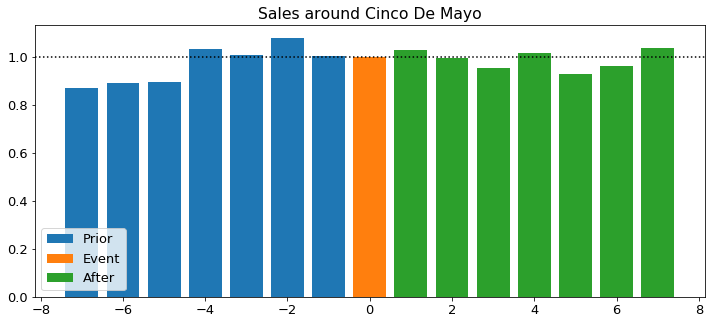

Mother's day


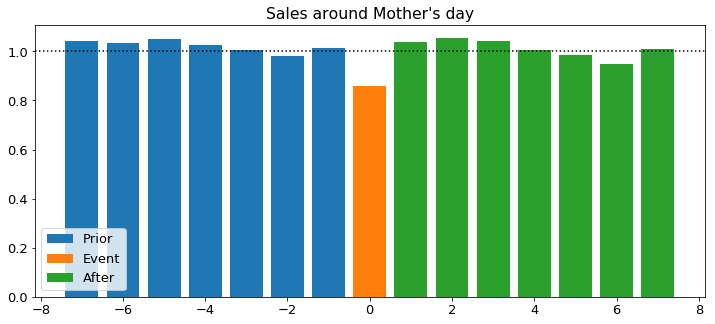

MemorialDay


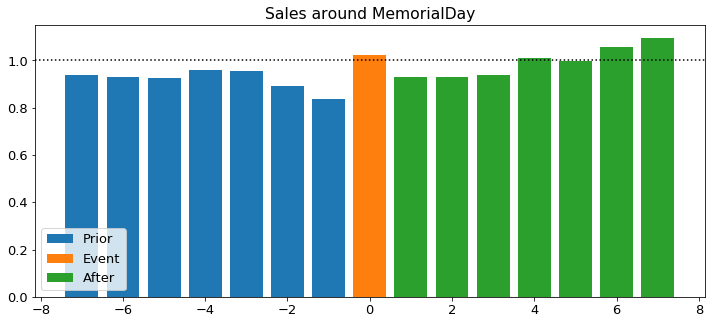

NBAFinalsStart


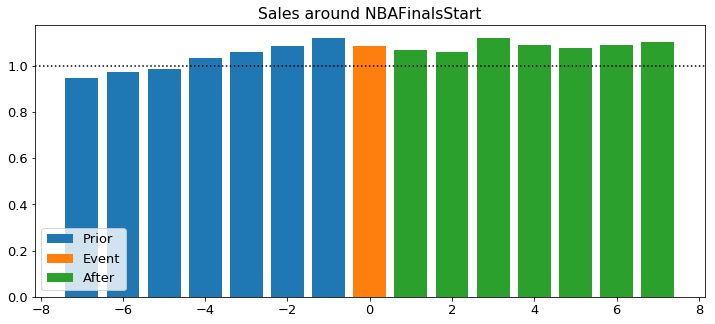

NBAFinalsEnd


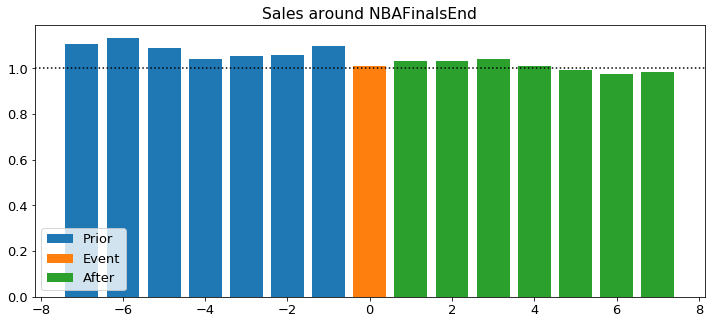

Father's day


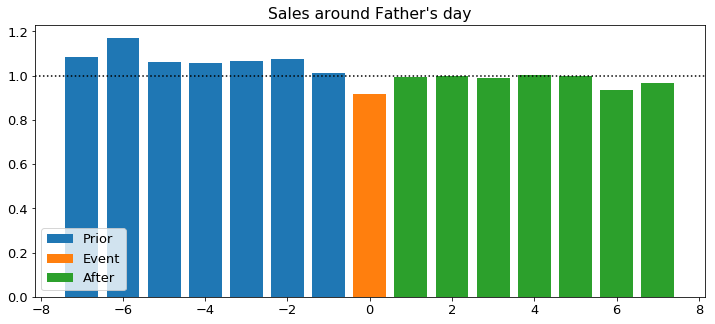

IndependenceDay


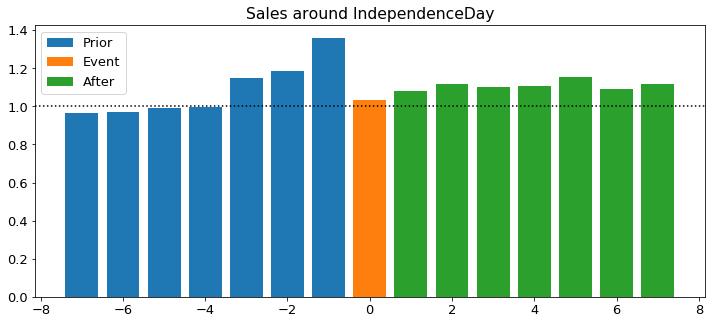

Ramadan starts


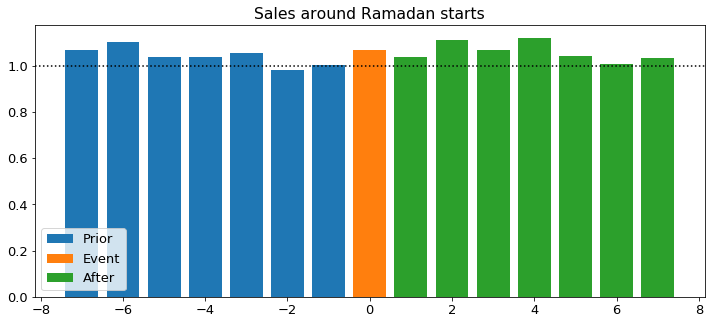

Eid al-Fitr


/Users/joeranbosma/opt/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


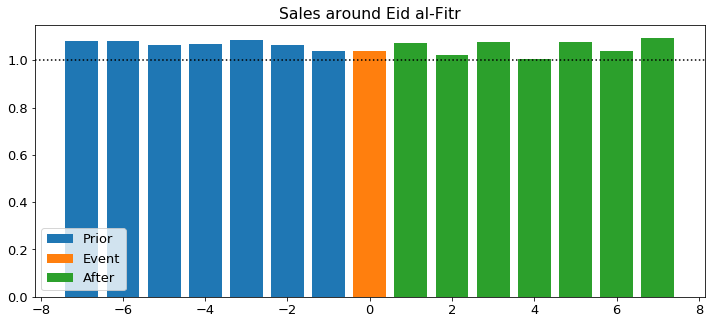

LaborDay


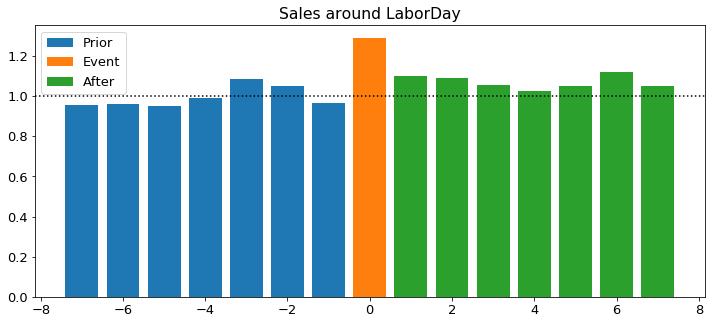

ColumbusDay


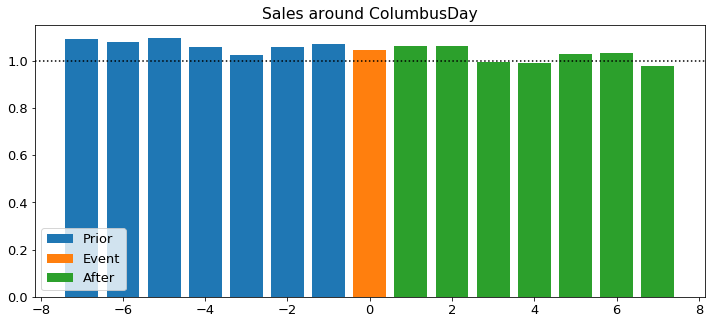

Halloween


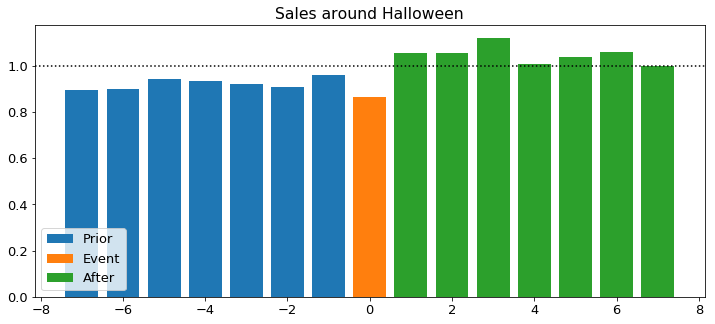

EidAlAdha


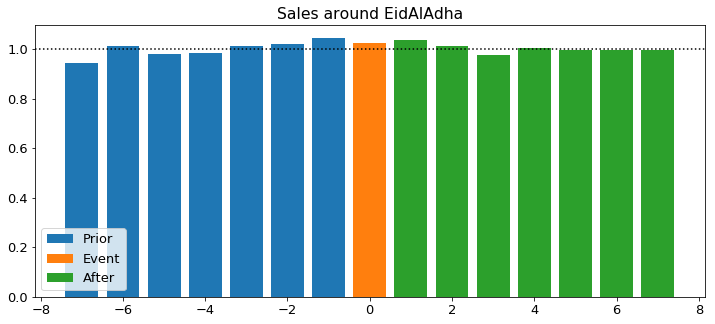

VeteransDay


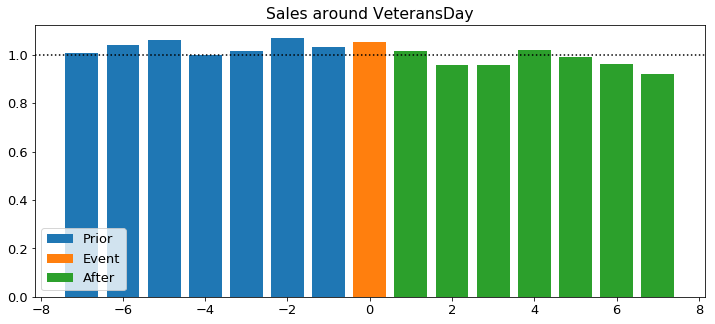

Thanksgiving


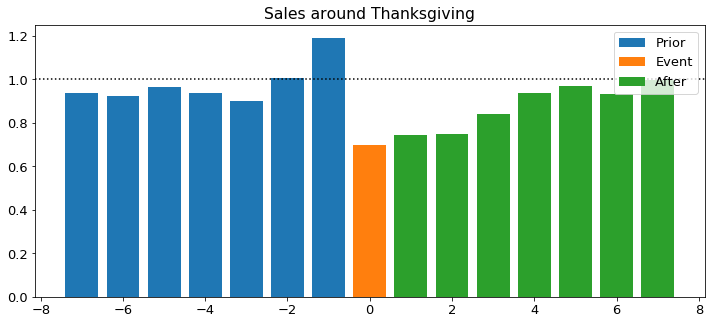

Christmas


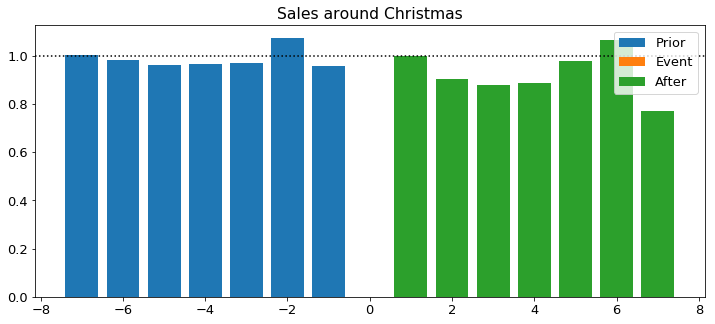

Chanukah End


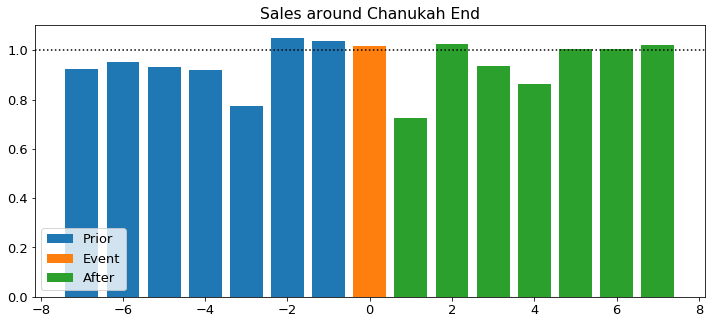

NewYear


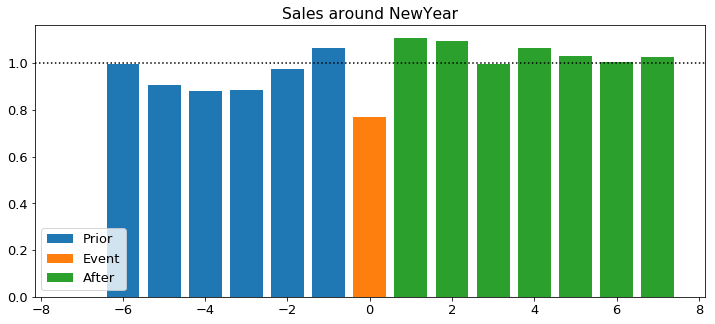

OrthodoxChristmas


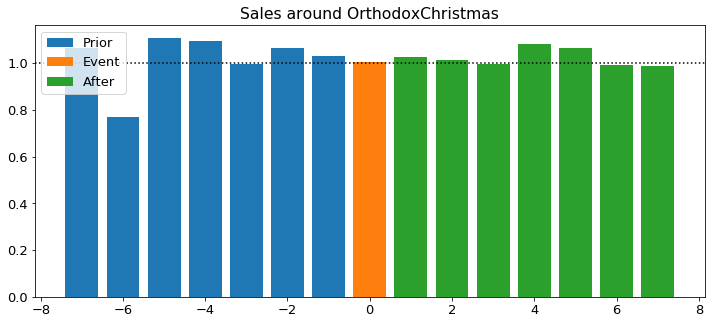

MartinLutherKingDay


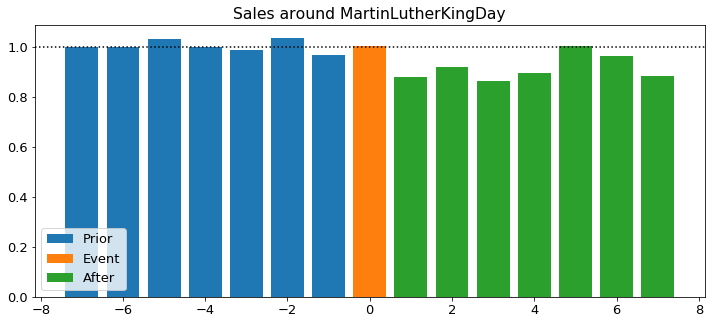

Easter


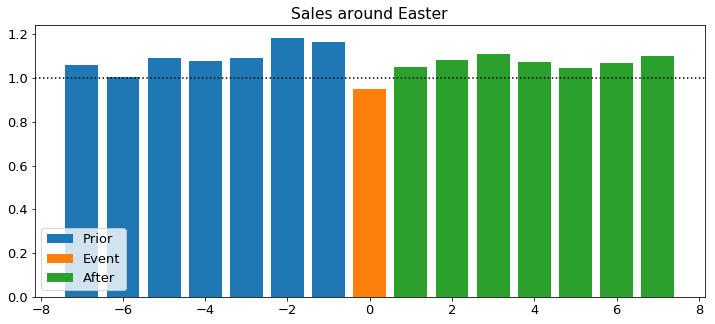

In [31]:
for event_name in calendar.event_name_1.unique():
    print(event_name)
    # select days with that event
    day_list = list(calendar[calendar.event_name_1 == event_name].d)
    day_list = [d for d in day_list if d in sales.index]
    # convert to array of integers
    day_list = np.array([int(col[2:]) for col in day_list])
    
    # calculate sales prior and after event
    sales_prior, sales_after = [], []
    for i in range(1, 1+7):
        # sales prior
        d_ls = ['d_%d'%(d-i) for d in day_list]
        sales_prior.append( sales.loc[d_ls].mean().mean() )
        
        # sales after
        d_ls = ['d_%d'%(d+i) for d in day_list]
        sales_after.append( sales.loc[d_ls].mean().mean() )
    
    # calculate sales at event
    d_ls = ['d_%d'%d for d in day_list]
    sales_event = sales.loc[d_ls].mean().mean()
    
    # plot sales
    x_prior = -1 - np.arange(len(sales_prior))
    x_after = 1 + np.arange(len(sales_after))

    f, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.axhline(1, linestyle=':', color='k')
    ax.bar(x_prior, height=sales_prior, label="Prior")
    ax.bar(0, height=sales_event, label="Event")
    ax.bar(x_after, height=sales_after, label="After")
    ax.set_title("Sales around {}".format(event_name))
    ax.legend()
    plt.show()

In [5]:
def preprocess_events(sales, prices=None, calendar=None, norm=None):
    """Convert sales to a suitable format for the BatchCreator"""
    # prices and calendar inputs are for compatibility
    
    # Calculate aggregated sales
    df = sales.groupby(['store_id']).sum()
    
    # Transpose sales such that d_num_start, ... is the index
    df = df.T
    
    # Normalize sales
    if norm is None:
        norm = df.max().max()
    df /= norm
    
    # add one-hot encoded special events
    d_list = select_day_nums(df, as_int=False, axis=0)
    events = pd.get_dummies(calendar.set_index('d').loc[d_list].event_name_1)
    events.index = list(events.index)
    
    # Merging is not nice to me, but this works..
    cols = list(df.columns); cols.extend(list(events.columns))
    df = pd.concat((df, events), axis=1, ignore_index=True)
    df.columns = cols
    
    return df, norm

In [6]:
# Get suitable train df
train_df, train_norm = preprocess_events(sales_train, calendar=calendar)

labels = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
features = {
    'inp_cnn': labels,
    'inp_mlp': [col for col in train_df.columns if col not in labels]
}

# Set up batch creator
window_in, window_out = 28, 28
batch_creator = BatchCreator(df=train_df, features=features, labels=labels, 
                             window_in=window_in, window_out=window_out)

In [81]:
from tensorflow.keras.layers import Flatten, concatenate

def get_model(inp_shape_cnn, inp_shape_mlp, out_shape, loss="MSE"):
    # clear previous sessions
    K.clear_session()

    # add first layer with correct input size
    inp_cnn = Input(shape=inp_shape_cnn, name="inp_cnn")
    x = Reshape((np.prod(inp_shape_cnn), 1))(inp_cnn)
    
    x = Conv1D( 8, kernel_size=3, padding="same", activation="relu")(x)
    x = Conv1D(16, kernel_size=3, padding="same", activation="relu")(x)
    x = Conv1D(32, kernel_size=3, padding="same", activation="relu")(x)
    x = Conv1D( 1, kernel_size=1, activation="relu")(x)
    x = Flatten()(x)
    
    inp_mlp = Input(shape=inp_shape_mlp, name="inp_mlp")
    y = Flatten()(inp_mlp)
    y = concatenate([x, y])
#     y = Dense(512, activation="relu")(y)
    out = Dense(np.prod(out_shape), activation="linear", name="output")(y)
    out = Reshape(out_shape)(out)
    
    model = Model(inputs=[inp_cnn, inp_mlp], outputs=out)

    model.compile(loss=loss, optimizer="adam", metrics=[loss])
    
    return model

model = get_model(inp_shape_cnn=(window_in, len(features["inp_cnn"])), 
                  inp_shape_mlp=(window_in, len(features["inp_mlp"])),
                  out_shape=(window_out, batch_creator.n_labels),
                  loss=make_loss(ref, train_norm=train_norm))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_cnn (InputLayer)            [(None, 28, 10)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 280, 1)       0           inp_cnn[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 280, 8)       32          reshape[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 280, 16)      400         conv1d[0][0]                     
______________________________________________________________________________________________

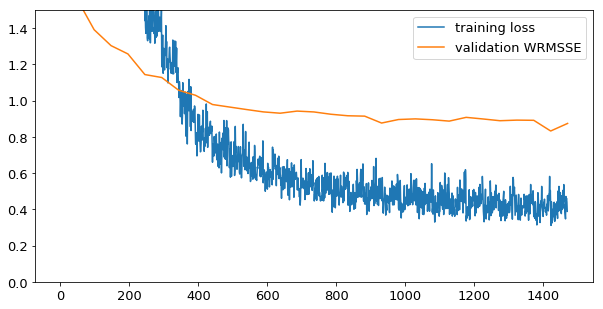

49/49 [==============================] - 8s 153ms/step - loss: 0.4148 - WRMSSE_store: 0.4148


In [35]:
logger = Logger(ref=ref, cv_generator=cv_generator, prices=sell_prices, calendar=calendar,
                train_norm=train_norm, features=features, labels=labels, preprocess_func=preprocess_events, 
                agent=AggregateAgent(model=model, train_norm=train_norm, features=features, 
                                     labels=labels, window_in=window_in),
                folds = np.arange(1, 1+10), plot_loss_max=1.5)

history = model.fit(batch_creator.flow(), epochs=30,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

## Evaluate performance

Mean WRMSSE level 3: 0.8740078859869428


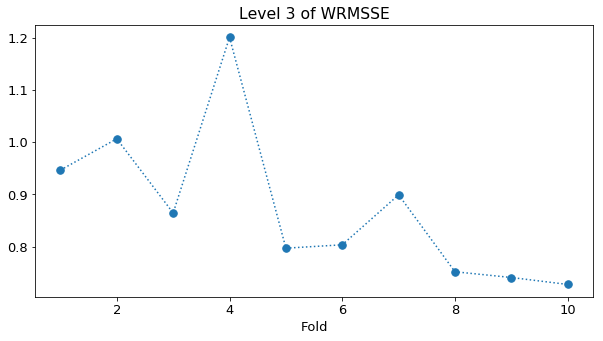

In [36]:
# evaluate model on final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()

**Result**: training score decreased significantly, but validation score is higher that without the information about the events. The system is overfitting. 

## Fix CNN of sales
The model above flattens the aggregated sales, creating a flat 280 elements input. However, these are the aggregated sales of 10 stores over 28 days. Feed the different stores as different inputs. Ignore the special events for now. 

In [7]:
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
features = {'inp_cnn_{}'.format(i): [store_id] for (i, store_id) in enumerate(store_ids)}
features

{'inp_cnn_0': ['CA_1'],
 'inp_cnn_1': ['CA_2'],
 'inp_cnn_2': ['CA_3'],
 'inp_cnn_3': ['CA_4'],
 'inp_cnn_4': ['TX_1'],
 'inp_cnn_5': ['TX_2'],
 'inp_cnn_6': ['TX_3'],
 'inp_cnn_7': ['WI_1'],
 'inp_cnn_8': ['WI_2'],
 'inp_cnn_9': ['WI_3']}

In [8]:
# Get suitable train df
train_df, train_norm = preprocess_events(sales_train, calendar=calendar)

labels = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

# Set up batch creator
window_in, window_out = 28, 28
batch_creator = BatchCreator(df=train_df, features=features, labels=labels, 
                             window_in=window_in, window_out=window_out)

# test batch creator
_ = next(batch_creator.flow())

In [9]:
from tensorflow.keras.layers import Flatten, concatenate

def get_model(inp_shape_cnn, out_shape, loss="MSE"):
    # clear previous sessions
    K.clear_session()
    
    # loop over last dimension of input shape: the stores
    cnn_input_list = []
    cnn_output_list = []
    for store_num in range(inp_shape_cnn[-1]):
        inp_shape = inp_shape_cnn[:-1]
        
        # add first layer with correct input size
        inp_cnn = Input(shape=(*inp_shape, 1), name="inp_cnn_{}".format(store_num))
        x = Reshape((np.prod(inp_shape), 1))(inp_cnn)

        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
        x = MaxPooling1D()(x)
        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
        x = MaxPooling1D()(x)
        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
#         x = Conv1D( 6, kernel_size=3, padding="valid", activation="relu")(x)
#         x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
#         x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
#         x = Conv1D(10, kernel_size=3, padding="valid", activation="relu")(x)
#         x = Conv1D(10, kernel_size=3, padding="valid", activation="relu")(x)
#         x = Conv1D(12, kernel_size=3, padding="valid", activation="relu")(x)
#         x = Conv1D(12, kernel_size=3, padding="valid", activation="relu")(x)
#         x = Conv1D(14, kernel_size=3, padding="valid", activation="relu")(x)
        x = Flatten()(x)
        
        # add input and output of this store's pipeline to list
        cnn_input_list.append(inp_cnn)
        cnn_output_list.append(x)
    
    # concatenate output of cnn pipelines
    x = concatenate(cnn_output_list)
    
    # add output for the stores' sales
    x = Dense(np.prod(out_shape), activation="linear", name="output")(x)
    out = Reshape(out_shape)(x)
    
    model = Model(inputs=cnn_input_list, outputs=out)

    model.compile(loss=loss, optimizer="adam", metrics=[loss])
    
    return model

model = get_model(inp_shape_cnn=(window_in, len(features)),
                  out_shape=(window_out, batch_creator.n_labels),
                  loss=make_loss(ref, train_norm=train_norm))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_cnn_0 (InputLayer)          [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
inp_cnn_1 (InputLayer)          [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
inp_cnn_2 (InputLayer)          [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
inp_cnn_3 (InputLayer)          [(None, 28, 1)]      0                                            
______________________________________________________________________________________________

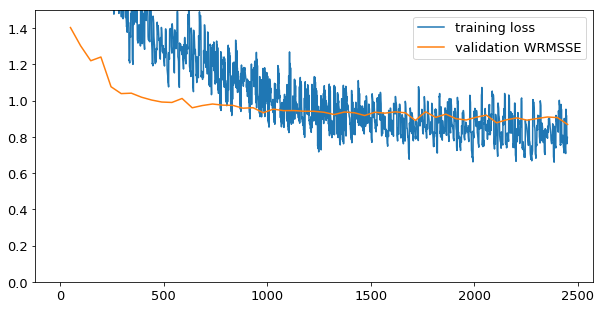

49/49 [==============================] - 6s 118ms/step - loss: 0.8402 - WRMSSE_store: 0.8402


In [13]:
logger = Logger(ref=ref, cv_generator=cv_generator, prices=sell_prices, calendar=calendar,
                train_norm=train_norm, features=features, labels=labels, preprocess_func=preprocess_events, 
                agent=AggregateAgent(model=model, train_norm=train_norm, features=features, 
                                     labels=labels, window_in=window_in),
                folds = np.arange(1, 1+10), plot_loss_max=1.5)

history = model.fit(batch_creator.flow(), epochs=50, workers=4, use_multiprocessing=True,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

Mean WRMSSE level 3: 0.9176772272336574


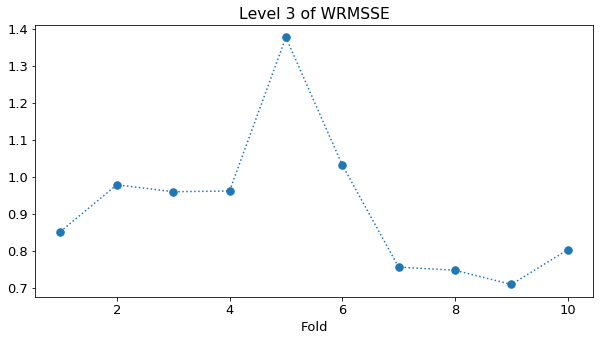

In [12]:
# evaluate model on final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()

## Include events
Investigate including events. Start with most impactful events. 

### Proof of concepts: most impactful events
Include:  
ValentinesDay, PresidentsDay, Mother's day, MemorialDay, NBAFinalsStart, Father's day, IndependenceDay, LaborDay, Thanksgiving, Christmas, Chanukah End, NewYear, Easter. 

In [6]:
event_names = ["ValentinesDay", "PresidentsDay", "Mother's day", "MemorialDay", 
               "NBAFinalsStart", "Father's day", "IndependenceDay", "LaborDay", 
               "Thanksgiving", "Christmas", "Chanukah End", "NewYear", "Easter"]

In [7]:
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
features = {'inp_cnn_{}'.format(i): [store_id] for (i, store_id) in enumerate(store_ids)}
features['inp_mlp'] = event_names
features

{'inp_cnn_0': ['CA_1'],
 'inp_cnn_1': ['CA_2'],
 'inp_cnn_2': ['CA_3'],
 'inp_cnn_3': ['CA_4'],
 'inp_cnn_4': ['TX_1'],
 'inp_cnn_5': ['TX_2'],
 'inp_cnn_6': ['TX_3'],
 'inp_cnn_7': ['WI_1'],
 'inp_cnn_8': ['WI_2'],
 'inp_cnn_9': ['WI_3'],
 'inp_mlp': ['ValentinesDay',
  'PresidentsDay',
  "Mother's day",
  'MemorialDay',
  'NBAFinalsStart',
  "Father's day",
  'IndependenceDay',
  'LaborDay',
  'Thanksgiving',
  'Christmas',
  'Chanukah End',
  'NewYear',
  'Easter']}

In [8]:
# Get suitable train df
train_df, train_norm = preprocess_events(sales_train, calendar=calendar)

labels = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

# Set up batch creator
window_in, window_out = 28, 28
batch_creator = BatchCreator(df=train_df, features=features, labels=labels, 
                             window_in=window_in, window_out=window_out)

In [9]:
from tensorflow.keras.layers import Flatten, concatenate

def get_model(inp_shape_cnn, inp_shape_mlp, out_shape, bottleneck_num, loss="MSE"):
    # clear previous sessions
    K.clear_session()
    
    # loop over last dimension of input shape: the stores
    cnn_input_list = []
    cnn_output_list = []
    for store_num in range(inp_shape_cnn[-1]):
        inp_shape = inp_shape_cnn[:-1]
        
        # add first layer with correct input size
        inp_cnn = Input(shape=(*inp_shape, 1), name="inp_cnn_{}".format(store_num))
        x = Reshape((np.prod(inp_shape), 1))(inp_cnn)

        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
        x = MaxPooling1D()(x)
        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
        x = MaxPooling1D()(x)
        x = Conv1D( 8, kernel_size=3, padding="valid", activation="relu")(x)
        x = Flatten()(x)
        
        # add input and output of this store's pipeline to list
        cnn_input_list.append(inp_cnn)
        cnn_output_list.append(x)
    
    # concatenate output of cnn pipelines
    x = concatenate(cnn_output_list)
    
    # input for special events
    inp_mlp = Input(shape=inp_shape_mlp, name="inp_mlp")
    y = Flatten()(inp_mlp)
    # y = Dense(np.prod(inp_shape_mlp))(y)
    y = Dense(bottleneck_num, name="events_bottleneck")(y)  # create bottleneck
    y = Dense(np.prod(out_shape))(y)
    
    # z = concatenate([x, y])
    
    # add output for the stores' sales
    z = Dense(np.prod(out_shape), activation="linear")(x)
    z = multiply([z, y])
    out = Reshape(out_shape, name="output")(z)
    
    model = Model(inputs=[*cnn_input_list, inp_mlp], outputs=out)

    model.compile(loss=loss, optimizer="adam", metrics=[loss])
    
    return model

model = get_model(inp_shape_cnn=(window_in, len(store_ids)),
                  inp_shape_mlp=(window_in, len(event_names)),
                  out_shape=(window_out, batch_creator.n_labels),
                  bottleneck_num=28,
                  loss=make_loss(ref, train_norm=train_norm))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_cnn_0 (InputLayer)          [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
inp_cnn_1 (InputLayer)          [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
inp_cnn_2 (InputLayer)          [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
inp_cnn_3 (InputLayer)          [(None, 28, 1)]      0                                            
______________________________________________________________________________________________

TypeError: unorderable types: float() > NoneType()

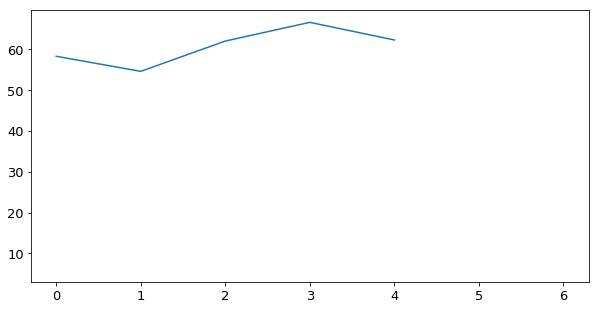

In [10]:
logger = Logger(ref=ref, cv_generator=cv_generator, prices=sell_prices, calendar=calendar,
                train_norm=train_norm, features=features, labels=labels, preprocess_func=preprocess_events, 
                agent=AggregateAgent(model=model, train_norm=train_norm, features=features, 
                                     labels=labels, window_in=window_in),
                folds = np.arange(1, 1+10), plot_loss_max=1.5)

history = model.fit(batch_creator.flow(), epochs=50, #workers=4, use_multiprocessing=True,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

Mean WRMSSE level 3: 0.8736303341620065


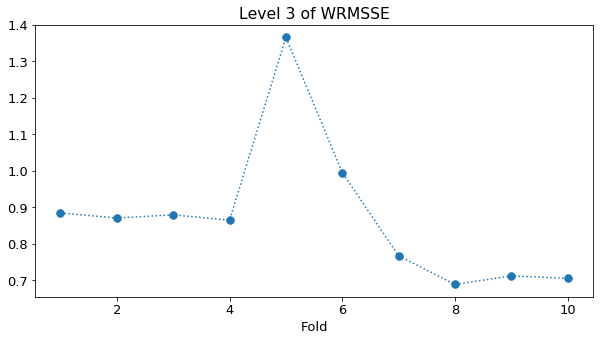

In [37]:
# evaluate model on final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()

## Test bottleneck size

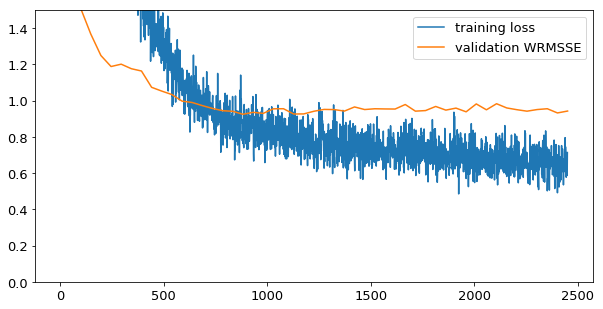

49/49 [==============================] - 25s 506ms/step - loss: 0.6426 - WRMSSE_store: 0.6426


In [11]:
bottleneck_options = [1, 3, 10, 28, 84, 280]
logger_list = []

for bottleneck_num in bottleneck_options:

    model = get_model(inp_shape_cnn=(window_in, len(store_ids)),
                      inp_shape_mlp=(window_in, len(event_names)),
                      out_shape=(window_out, batch_creator.n_labels),
                      bottleneck_num=bottleneck_num,
                      loss=make_loss(ref, train_norm=train_norm))

    logger = Logger(ref=ref, cv_generator=cv_generator, prices=sell_prices, calendar=calendar,
                    train_norm=train_norm, features=features, labels=labels, preprocess_func=preprocess_events, 
                    agent=AggregateAgent(model=model, train_norm=train_norm, features=features, 
                                         labels=labels, window_in=window_in),
                    folds = np.arange(1, 1+10), plot_loss_max=1.5)

    history = model.fit(batch_creator.flow(), epochs=50, #workers=4, use_multiprocessing=True,
                        steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                        callbacks=[logger])
    
    logger_list.append(logger)

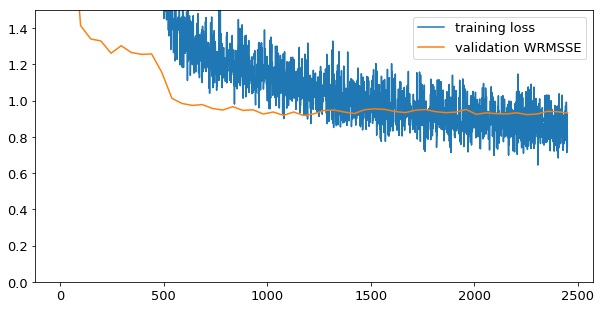

Mean WRMSSE level 3: 0.9317118165510644


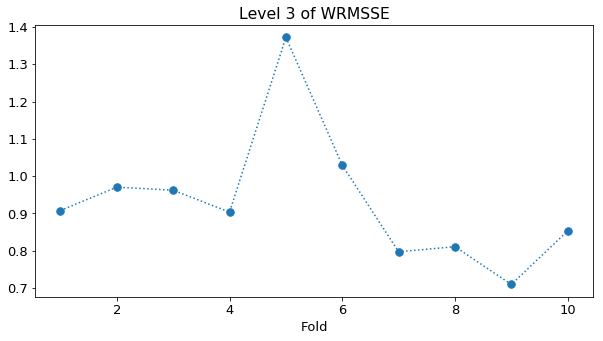

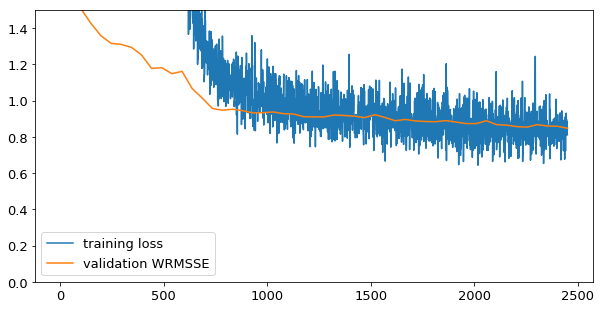

Mean WRMSSE level 3: 0.8475509614884544


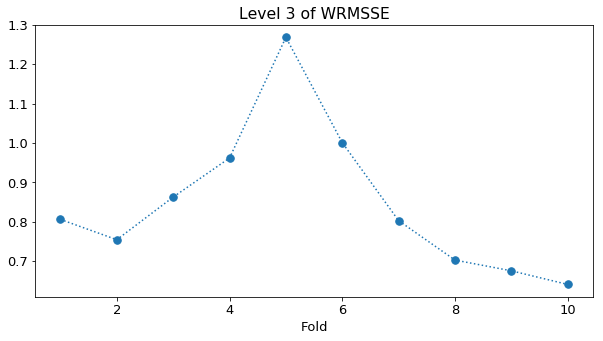

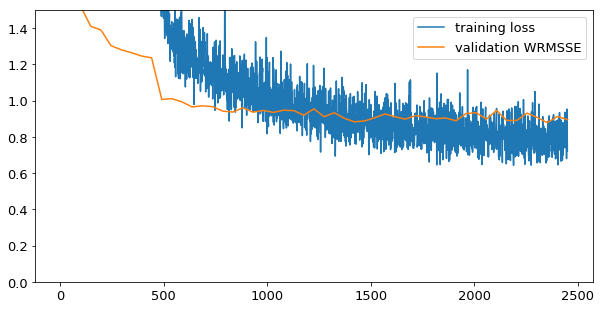

Mean WRMSSE level 3: 0.8947262445162772


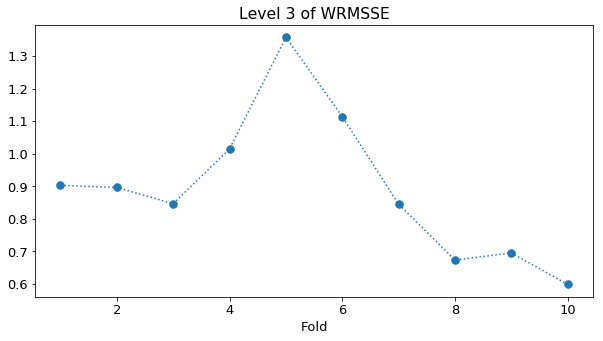

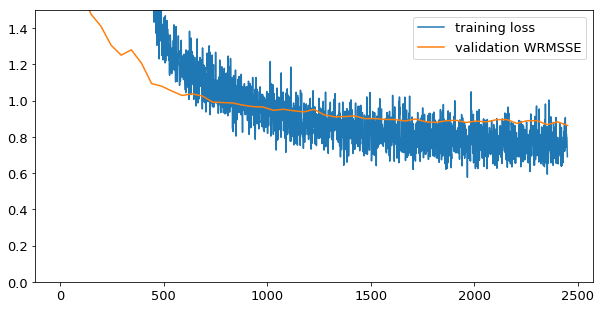

Mean WRMSSE level 3: 0.8625796788191874


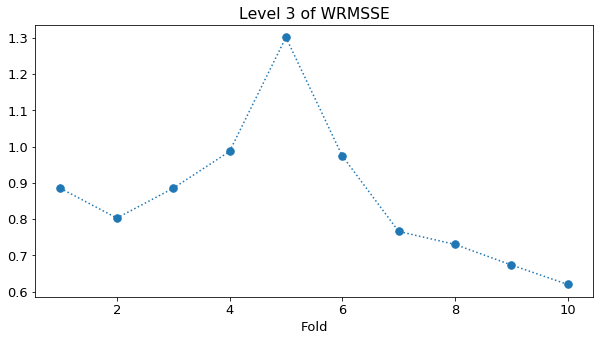

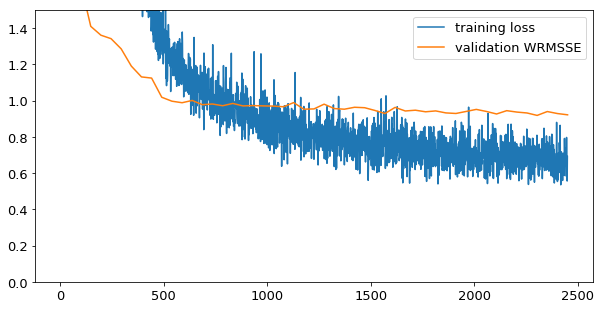

Mean WRMSSE level 3: 0.9215752307080548


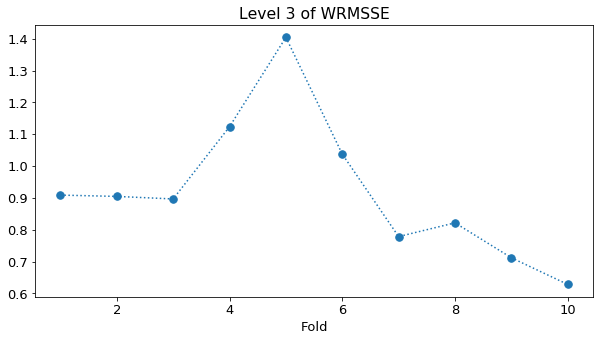

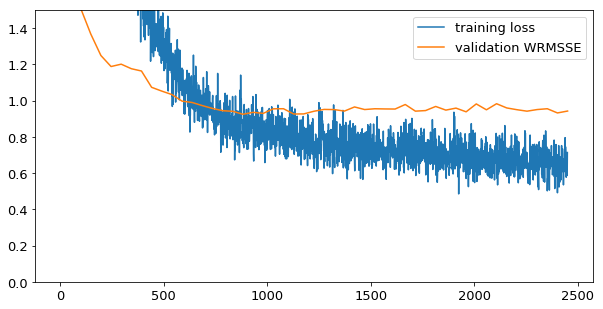

Mean WRMSSE level 3: 0.9423626256116364


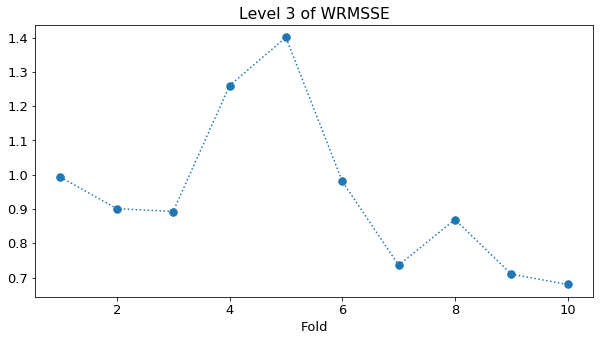

In [12]:
mean_scores = []

for logger in logger_list:
    # show training
    logger.plot(clear=False)
    
    # evaluate model on final 10 folds
    WRMSSE_mean, WRMSSE_list = logger.validate()
    print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))
    
    f, ax = plt.subplots(1, 1)
    ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
    ax.set_xlabel("Fold")
    ax.set_title("Level 3 of WRMSSE")
    plt.show()
    
    mean_scores.append(WRMSSE_mean)

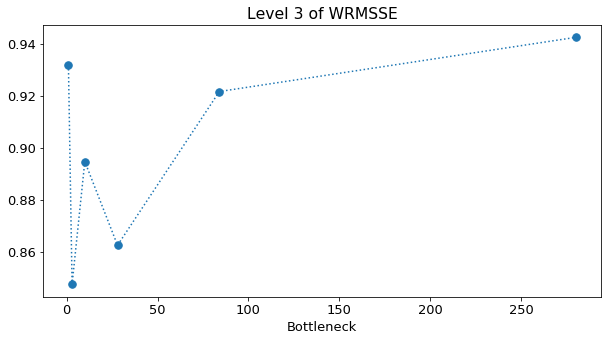

In [13]:
# plot mean scores
f, ax = plt.subplots(1, 1)
ax.plot(bottleneck_options, mean_scores, '.:', ms=15)
ax.set
ax.set_xlabel("Bottleneck")
ax.set_title("Level 3 of WRMSSE")
plt.show()